In [1]:
import os
import sys
import glob
import h5py
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Dataset
First we download the dataset and caal it as 'data'

In [ ]:
#scarica il dataset modelnet40 usato nell'articolo DGCNN

!wget --no-check-certificate https://shapenet.cs.stanford.edu/media/modelnet40_ply_hdf5_2048.zip
!unzip modelnet40_ply_hdf5_2048.zip
!mv modelnet40_ply_hdf5_2048 data/
!rm -f modelnet40_ply_hdf5_2048.zip

--2021-12-17 13:10:35--  https://shapenet.cs.stanford.edu/media/modelnet40_ply_hdf5_2048.zip
Resolving shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)... 171.67.77.19
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 435212151 (415M) [application/zip]
Saving to: ‘modelnet40_ply_hdf5_2048.zip’

p                    32%[=====>              ] 133.27M   147KB/s    eta 19m 50s

Now we define utility functions to read data and labels and get data augmentation
>### Notes
>$glob$ is a built-in phyton mudole, it is a general term used to define techniques to match specified patterns according to rules related to Unix shell. More practical, it is used to retrieve files/pathnames matching a specified pattern. we can also use wildcards (*, ?, [ranges]) apart from exact string search to make path retrieval more simple.

>$os$ module in Python provides functions for interacting with the operating system. In particular $os.path$ module contains some useful functions on pathnames. The path parameters are either strings or bytes . These functions here are used for different purposes such as for merging, normalizing and retrieving path names in python. The method $os.path.join( , )$ has two arguments. The first is a path-like object representing a file system path, the second represents the path components to be joined. 

>$.h5$ is a format for scientific data. It contains multidimentional arrays

In [2]:
print(os.path.join('data',''))

data/


In [3]:
#legge dati e label
def load_data_cls(partition):#Used in class Dataset
    DATA_DIR = 'data'
    all_data = []
    all_label = []
    for h5_name in glob.glob(os.path.join(DATA_DIR,'*%s*.h5'%partition)):
        f = h5py.File(h5_name, 'r+')
        data = f['data'][:].astype('float32')
        label = f['label'][:].astype('int64')
        f.close()
        all_data.append(data)
        all_label.append(label)
    all_data = np.concatenate(all_data, axis=0)
    all_label = np.concatenate(all_label, axis=0)
    return all_data, all_label

In [4]:
# funzioni per dataugmentation (random traslation, rotations, jitter delle pointlcoud)
def translate_pointcloud(pointcloud):
    xyz1 = np.random.uniform(low=2./3., high=3./2., size=[3])
    xyz2 = np.random.uniform(low=-0.2, high=0.2, size=[3])
       
    translated_pointcloud = np.add(np.multiply(pointcloud, xyz1), xyz2).astype('float32')
    return translated_pointcloud

def rotate_pointcloud(pointcloud):
    theta = np.pi*2 * np.random.uniform()
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    pointcloud[:,[0,2]] = pointcloud[:,[0,2]].dot(rotation_matrix) # random rotation (x,z)
    return pointcloud

def jitter_pointcloud(pointcloud, sigma=0.01, clip=0.02):
    N, C = pointcloud.shape
    pointcloud += np.clip(sigma * np.random.randn(N, C), -1*clip, clip)
    return pointcloud

In [5]:
# classe per leggere il dataset e formattarlo in modo appopriato per l'input della DGCNN 
# il dataset contiene tre tipi di oggetti:
# points: la point cloud che contiene le coordinate dei punti: shape (N, P, C_p) N=numero esempi, P=numero punti per ogni esempio, C_p=numero feature associate a ciascun punto
# features: le feature associate ad ogni punto (possono essere le stesse coordinate o queste + ulteriori features): shape (N, P, C_f)
# mask: una mask che ha valore 1 o 0 per mascherare punti non fisici (quando P di un dato evento è inferiore alla dimensione con cui si e' fissato P): shape (N,P,1) 

class Dataset(object):
    def __init__(self, partition='train', num_points=1024): 
        self.data, self.label = load_data_cls(partition)
        self.partition = partition 
        self.num_points = num_points
        self._values = {}
        self._label = None
        self._load()
        
    def __len__(self):
        return len(self._label)

    def _load(self):
        pointcloud = self.data[:, :self.num_points, :]
        # per questo esempio tutti gli eventi hanno lo stesso numero di punti quindi la mask
        # e' una matrice di 1
        mask = np.ones(shape=(pointcloud.shape[0],pointcloud.shape[1],1)) 
        #if self.partition == 'train':
        #    pointcloud = translate_pointcloud(pointcloud)
        self._label = tf.keras.utils.to_categorical(self.label, num_classes=40)
        self._values['points'] = pointcloud
        self._values['features'] = pointcloud
        self._values['mask'] = mask
    
    def __getitem__(self, key):
        if key=='label':
            return self._label
        else:
            return self._values[key]
    
    @property
    def X(self):
        return self._values
    
    @property
    def y(self):
        return self._label

    def shuffle(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        shuffle_indices = np.arange(self.__len__())
        np.random.shuffle(shuffle_indices)
        for k in self._values:
            self._values[k] = self._values[k][shuffle_indices]
        self._label = self._label[shuffle_indices]  

Here we pratically build the trainand test datasets, and then we look at their shapes

In [6]:
#legge i dati di training e test
train = Dataset(partition='train', num_points=1024)
test = Dataset(partition='test', num_points=1024)

In [26]:
# mostra il contenuto dei dati
print(train['points'].shape)
print(test['points'].shape)
print(train['features'].shape)
print(test['features'].shape)
print(train['mask'].shape)
print(test['mask'].shape)
print(train)

(9840, 1024, 3)
(2468, 1024, 3)
(9840, 1024, 3)
(2468, 1024, 3)
(9840, 1024, 1)
(2468, 1024, 1)


### Model
Here we buid our net.

>### Note
>The method $tf.nn.top_k(input, k, name=None)$ returns the largest k numbers of each line in input, and return the index of their location.

>The method $tf.tile(input, multiplies, name=None)$ creates a new tensor by replicating input multiples times. The output tensor's i'th dimension has input.dims(i) * multiples[i] elements, and the values of input are replicated multiples[i] times along the 'i'th dimension. For example, tiling [a b c d] by [2] produces [a b c d a b c d].

>The method $tf.gather_nd(params, indices, batch_dims=0, name=None)$  slices from params into a Tensor with shape specified by indices. Whereas in tf.gather(...) indices defines slices into the first dimension of params, in tf.gather_nd(...), indices defines slices into the first N dimensions of params, where N = indices.shape[-1].

> The $tf.squeeze(input, axis=None, name=None)$ method, given a tensor input, returns a tensor of the same type with all dimensions of size $1$ removed. If you don't want to remove all size $1$ dimensions, you can remove specific size $1$ dimensions by specifying axis.

>$pass$ it is a null statement that is commonly used as a placeholder ('segnaposto').

> $tf.keras.Input()$ is used to instantiate a Keras tensor. A Keras tensor is a symbolic tensor-like object, which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model. For instance, if $a$, $b$ and $c$ are Keras tensors, it becomes possible to do: $model = Model(input=[a, b], output=c)$

In [8]:
#DGCNN

# A shape is (N, P_A, C), B shape is (N, P_B, C)
# D shape is (N, P_A, P_B)
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):#It gives a name_scope at submitted operators, so 'r_A', when executed, will have name 'dmat/r_A'
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))#'Distance' between A and B
        return D
    
def knn(num_points, k, topk_indices, features): #k-nearest-neighbours
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1)) #(N, P, K, 1)
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2) indices ha, per ogni elemento, due numeri: il primo scala rispetto al batch
        return tf.gather_nd(features, indices)
    
def edge_conv(points, features, num_points, K, channels, with_bn=True, activation='relu', pooling='max', name='edgeconv'):
    """EdgeConv
    Args:
        num_points: number of points per event (1024)
        K: int, number of neighbors
        in_channels: # of input channels
        channels: tuple of output channels
        pooling: pooling method ('max' or 'average')
    Inputs:
        points: (N, P, C_p)
        features: (N, P, C_0)
    Returns:
        transformed points: (N, P, C_out), C_out = channels[-1]
    """

    with tf.name_scope('edgeconv'):

        # distance
        D = batch_distance_matrix_general(points, points)  # (N, P, P)
        _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)  Becouse top_k returns the largest, using -D we get the smallest values
        indices = indices[:, :, 1:]  # (N, P, K); the 1: allow to esclude distance between each point to itself

        fts = features # (N, P, C)
        knn_fts = knn(num_points, K, indices, fts)  # (N, P, K, C)
        knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  # (N, P, K, C); copia le C K  volte
        knn_fts = tf.concat([knn_fts_center, tf.subtract(knn_fts, knn_fts_center)], axis=-1)  # (N, P, K, 2*C); abbiamo 2*C perche anniamo le C del centro e le C del vicino selezionato

        x = knn_fts
        for idx, channel in enumerate(channels):
            x = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, data_format='channels_last',
                                    use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_conv%d' % (name, idx))(x)
            if with_bn:
                x = keras.layers.BatchNormalization(name='%s_bn%d' % (name, idx))(x)
            if activation:
                x = keras.layers.Activation(activation, name='%s_act%d' % (name, idx))(x)

        if pooling == 'max':
            fts = tf.reduce_max(x, axis=2)  # (N, P, C')
        else:
            fts = tf.reduce_mean(x, axis=2)  # (N, P, C')

        # shortcut
        sc = keras.layers.Conv2D(channels[-1], kernel_size=(1, 1), strides=1, data_format='channels_last',
                                 use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_sc_conv' % name)(tf.expand_dims(features, axis=2))
        if with_bn:
            sc = keras.layers.BatchNormalization(name='%s_sc_bn' % name)(sc)
        sc = tf.squeeze(sc, axis=2)

        if activation:
            return keras.layers.Activation(activation, name='%s_sc_act' % name)(sc + fts)  # (N, P, C')
        else:
            return sc + fts


def _DGCNN_base(points, features=None, mask=None, setting=None, fts_dict=None, name='DGCNN_SG'): #it is used by get_DGCNN to build the net
    # points : (N, P, C_coord)
    # features:  (N, P, C_features), optional
    # mask: (N, P, 1), optional

    with tf.name_scope(name):
        if features is None:
            features = points
        
        if mask is not None:
            mask = tf.cast(tf.not_equal(mask, 0), dtype='float32')  # 1 if valid
            coord_shift = tf.multiply(999., tf.cast(tf.equal(mask, 0), dtype='float32'))  # make non-valid positions to 99   
            
        fts = tf.squeeze( keras.layers.BatchNormalization(name='%s_fts_bn' % name)(tf.expand_dims(features, axis=2)) , axis=2)

        if mask is not None:#Ho spostato la maschera qui
            fts = tf.multiply(fts, mask)
        
        for layer_idx, layer_param in enumerate(setting.conv_params):# Here creates the 4 edge_conv layers
            K, channels = layer_param
            pts = tf.add(coord_shift, points) if layer_idx == 0 else tf.add(coord_shift, fts)
            fts = edge_conv(pts, fts, setting.num_points, K, channels, with_bn=True, activation='relu',
                            pooling=setting.conv_pooling, name='%s_%s%d' % (name, 'EdgeConv', layer_idx))
            string = 'fts_%d' % (layer_idx)
            fts_dict[string]=fts
            

        fts = tf.concat([fts_dict['fts_0'], fts_dict['fts_1'], fts_dict['fts_2'], fts_dict['fts_3']], axis=-1)
        fts = keras.layers.Dense(setting.num_points, activation='relu')(fts)         #HERE
        pool_avg = tf.reduce_mean(fts, axis=1)  # (N, C)
        pool_max = tf.reduce_max(fts, axis=1)  # (N, C)  ### HERE
        pool = tf.concat([pool_avg,pool_max], axis=-1)
        
        if setting.fc_params is not None:#Here it creates the FC layers
            x = pool
            for layer_idx, layer_param in enumerate(setting.fc_params):
                units, drop_rate = layer_param
                x = keras.layers.Dense(units, activation='relu')(x)
                if drop_rate is not None and drop_rate > 0:
                    x = keras.layers.Dropout(drop_rate)(x)
            out = keras.layers.Dense(setting.num_class, activation='softmax')(x)
            return out  # (N, num_classes)
        else:
            return pool


class _DotDict:
    pass

def get_DGCNN(num_classes, input_shapes):#Here we set all parameters of the net, its structure and then the _DGCNN_base really create it
    """
    Parameters
    ----------
    num_classes : int
        Number of output classes. Are classes that beongs to dataset, the ones we want train (e.g. ariplain, car,etc.)
    input_shapes : dict
        The shapes of each input (`points`, `features`, `mask`).
    """
    fts_dict = {}
    setting = _DotDict()
    setting.num_class = num_classes
    # conv_params: list of tuple in the format (K, (C1, C2, C3)); where c1, c2, c3 are MLP layers inside each edge conv, respectiveli...so at each edge coonv layer we can use dfferent numbers and lists
    setting.conv_params = [
        (20, (64, 64, 64)),  
        (20, (64, 64, 64)),
        (20, (128, 128, 128)),
        (20, (256, 256, 256)),
        ]
    # conv_pooling: 'average' or 'max'
    setting.conv_pooling = 'average'
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = [
        (512, 0.5),
        (256, 0.5),
        ]
    setting.num_points = input_shapes['points'][0]

    points = keras.Input(name='points', shape=input_shapes['points'])
    features = keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    mask = keras.Input(name='mask', shape=input_shapes['mask']) if 'mask' in input_shapes else None
    outputs = _DGCNN_base(points, features, mask, setting, fts_dict, name='DGCNN_SG')

    return keras.Model(inputs=[points, features, mask], outputs=outputs, name='DGCNN_SG')


In [23]:
num_classes = 40
input_shapes = {k:train[k].shape[1:] for k in train.X}
print(input_shapes)
model = get_DGCNN(num_classes, input_shapes)
print(type(input_shapes['features']))

{'points': (1024, 3), 'features': (1024, 3), 'mask': (1024, 1)}
<class 'tuple'>


In [10]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    logging.info('Learning rate: %f'%lr)
    return lr

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2022-01-20 11:20:08,502] INFO: Learning rate: 0.001000


Model: "DGCNN_SG"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
tf.math.not_equal (TFOpLambda)  (None, 1024, 1)      0           mask[0][0]                       
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 1024, 1)      0           tf.math.not_equal[0][0]          
__________________________________________________________________________________________________
tf.math.equal (TFOpLambda)      (None, 1024, 1)      0           tf.cast[0][0]                    
___________________________________________________________________________________________

In [12]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = 'DGCNN_modelbest_WITH_concat_and_mask.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]

In [13]:
# Training parameters
batch_size = 32
epochs = 50

In [14]:
train.shuffle()
model.fit(train.X, train.y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(test.X, test.y),
          shuffle=True,
          callbacks=callbacks)

2022-01-20 11:20:12.925661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
[2022-01-20 11:20:12,965] INFO: Learning rate: 0.001000


Epoch 1/50


2022-01-20 11:20:16.328546: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8300
2022-01-20 11:20:18.882631: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


      0/Unknown - 77s 0s/sample - loss: 2.7926 - accuracy: 0.3002
Epoch 00001: val_accuracy improved from -inf to 0.35251, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 85s 275ms/sample - loss: 2.7926 - accuracy: 0.3002 - val_loss: 2.5271 - val_accuracy: 0.3525 - lr: 0.0010


[2022-01-20 11:21:37,684] INFO: Learning rate: 0.001000


Epoch 2/50
  0/308 [..............................] - ETA: 0s - loss: 2.0099 - accuracy: 0.4583
Epoch 00002: val_accuracy improved from 0.35251 to 0.51256, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 71s 229ms/sample - loss: 2.0099 - accuracy: 0.4583 - val_loss: 1.6872 - val_accuracy: 0.5126 - lr: 0.0010


[2022-01-20 11:22:48,370] INFO: Learning rate: 0.001000


Epoch 3/50
  0/308 [..............................] - ETA: 0s - loss: 1.7184 - accuracy: 0.5164
Epoch 00003: val_accuracy improved from 0.51256 to 0.52634, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 227ms/sample - loss: 1.7184 - accuracy: 0.5164 - val_loss: 1.5116 - val_accuracy: 0.5263 - lr: 0.0010


[2022-01-20 11:23:58,430] INFO: Learning rate: 0.001000


Epoch 4/50
  0/308 [..............................] - ETA: 0s - loss: 1.5367 - accuracy: 0.5593
Epoch 00004: val_accuracy improved from 0.52634 to 0.61386, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 227ms/sample - loss: 1.5367 - accuracy: 0.5593 - val_loss: 1.3910 - val_accuracy: 0.6139 - lr: 0.0010


[2022-01-20 11:25:08,493] INFO: Learning rate: 0.001000


Epoch 5/50
  0/308 [..............................] - ETA: 0s - loss: 1.4005 - accuracy: 0.5871
Epoch 00005: val_accuracy improved from 0.61386 to 0.69895, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 228ms/sample - loss: 1.4005 - accuracy: 0.5871 - val_loss: 1.1183 - val_accuracy: 0.6989 - lr: 0.0010


[2022-01-20 11:26:18,633] INFO: Learning rate: 0.001000


Epoch 6/50
  0/308 [..............................] - ETA: 0s - loss: 1.2845 - accuracy: 0.6190
Epoch 00006: val_accuracy improved from 0.69895 to 0.72083, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 228ms/sample - loss: 1.2845 - accuracy: 0.6190 - val_loss: 0.9943 - val_accuracy: 0.7208 - lr: 0.0010


[2022-01-20 11:27:28,822] INFO: Learning rate: 0.001000


Epoch 7/50
  0/308 [..............................] - ETA: 0s - loss: 1.1844 - accuracy: 0.6443
Epoch 00007: val_accuracy improved from 0.72083 to 0.75000, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 227ms/sample - loss: 1.1844 - accuracy: 0.6443 - val_loss: 0.9015 - val_accuracy: 0.7500 - lr: 0.0010


[2022-01-20 11:28:38,822] INFO: Learning rate: 0.001000


Epoch 8/50
  0/308 [..............................] - ETA: 0s - loss: 1.1040 - accuracy: 0.6707
Epoch 00008: val_accuracy did not improve from 0.75000
308/308 [==============================] - 69s 226ms/sample - loss: 1.1040 - accuracy: 0.6707 - val_loss: 0.9617 - val_accuracy: 0.7281 - lr: 0.0010


[2022-01-20 11:29:48,313] INFO: Learning rate: 0.001000


Epoch 9/50
  0/308 [..............................] - ETA: 0s - loss: 1.0550 - accuracy: 0.6819
Epoch 00009: val_accuracy did not improve from 0.75000
308/308 [==============================] - 70s 226ms/sample - loss: 1.0550 - accuracy: 0.6819 - val_loss: 0.8643 - val_accuracy: 0.7500 - lr: 0.0010


[2022-01-20 11:30:57,866] INFO: Learning rate: 0.001000


Epoch 10/50
  0/308 [..............................] - ETA: 0s - loss: 1.0081 - accuracy: 0.7021
Epoch 00010: val_accuracy improved from 0.75000 to 0.75648, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 227ms/sample - loss: 1.0081 - accuracy: 0.7021 - val_loss: 0.8569 - val_accuracy: 0.7565 - lr: 0.0010


[2022-01-20 11:32:07,888] INFO: Learning rate: 0.001000


Epoch 11/50
  0/308 [..............................] - ETA: 0s - loss: 0.9654 - accuracy: 0.7102
Epoch 00011: val_accuracy improved from 0.75648 to 0.76297, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 228ms/sample - loss: 0.9654 - accuracy: 0.7102 - val_loss: 0.8659 - val_accuracy: 0.7630 - lr: 0.0010


[2022-01-20 11:33:18,094] INFO: Learning rate: 0.000100


Epoch 12/50
  0/308 [..............................] - ETA: 0s - loss: 0.7732 - accuracy: 0.7661
Epoch 00012: val_accuracy improved from 0.76297 to 0.82212, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 227ms/sample - loss: 0.7732 - accuracy: 0.7661 - val_loss: 0.6277 - val_accuracy: 0.8221 - lr: 1.0000e-04


[2022-01-20 11:34:28,139] INFO: Learning rate: 0.000100


Epoch 13/50
  0/308 [..............................] - ETA: 0s - loss: 0.7341 - accuracy: 0.7690
Epoch 00013: val_accuracy did not improve from 0.82212
308/308 [==============================] - 70s 226ms/sample - loss: 0.7341 - accuracy: 0.7690 - val_loss: 0.6150 - val_accuracy: 0.8217 - lr: 1.0000e-04


[2022-01-20 11:35:37,793] INFO: Learning rate: 0.000100


Epoch 14/50
  0/308 [..............................] - ETA: 0s - loss: 0.7014 - accuracy: 0.7791
Epoch 00014: val_accuracy improved from 0.82212 to 0.82658, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 228ms/sample - loss: 0.7014 - accuracy: 0.7791 - val_loss: 0.6032 - val_accuracy: 0.8266 - lr: 1.0000e-04


[2022-01-20 11:36:47,931] INFO: Learning rate: 0.000100


Epoch 15/50
  0/308 [..............................] - ETA: 0s - loss: 0.6882 - accuracy: 0.7813
Epoch 00015: val_accuracy improved from 0.82658 to 0.83955, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 227ms/sample - loss: 0.6882 - accuracy: 0.7813 - val_loss: 0.5799 - val_accuracy: 0.8395 - lr: 1.0000e-04


[2022-01-20 11:37:57,862] INFO: Learning rate: 0.000100


Epoch 16/50
  0/308 [..............................] - ETA: 0s - loss: 0.6730 - accuracy: 0.7915
Epoch 00016: val_accuracy improved from 0.83955 to 0.84117, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 227ms/sample - loss: 0.6730 - accuracy: 0.7915 - val_loss: 0.5825 - val_accuracy: 0.8412 - lr: 1.0000e-04


[2022-01-20 11:39:07,837] INFO: Learning rate: 0.000100


Epoch 17/50
  0/308 [..............................] - ETA: 0s - loss: 0.6462 - accuracy: 0.8021
Epoch 00017: val_accuracy improved from 0.84117 to 0.84684, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 227ms/sample - loss: 0.6462 - accuracy: 0.8021 - val_loss: 0.5715 - val_accuracy: 0.8468 - lr: 1.0000e-04


[2022-01-20 11:40:17,805] INFO: Learning rate: 0.000100


Epoch 18/50
  0/308 [..............................] - ETA: 0s - loss: 0.6423 - accuracy: 0.7988
Epoch 00018: val_accuracy did not improve from 0.84684
308/308 [==============================] - 70s 226ms/sample - loss: 0.6423 - accuracy: 0.7988 - val_loss: 0.5688 - val_accuracy: 0.8400 - lr: 1.0000e-04


[2022-01-20 11:41:27,316] INFO: Learning rate: 0.000100


Epoch 19/50
  0/308 [..............................] - ETA: 0s - loss: 0.6373 - accuracy: 0.8021
Epoch 00019: val_accuracy did not improve from 0.84684
308/308 [==============================] - 70s 226ms/sample - loss: 0.6373 - accuracy: 0.8021 - val_loss: 0.5630 - val_accuracy: 0.8391 - lr: 1.0000e-04


[2022-01-20 11:42:36,868] INFO: Learning rate: 0.000100


Epoch 20/50
  0/308 [..............................] - ETA: 0s - loss: 0.6176 - accuracy: 0.8091
Epoch 00020: val_accuracy did not improve from 0.84684
308/308 [==============================] - 70s 226ms/sample - loss: 0.6176 - accuracy: 0.8091 - val_loss: 0.5499 - val_accuracy: 0.8456 - lr: 1.0000e-04


[2022-01-20 11:43:46,567] INFO: Learning rate: 0.000100


Epoch 21/50
  0/308 [..............................] - ETA: 0s - loss: 0.6076 - accuracy: 0.8127
Epoch 00021: val_accuracy did not improve from 0.84684
308/308 [==============================] - 70s 226ms/sample - loss: 0.6076 - accuracy: 0.8127 - val_loss: 0.5477 - val_accuracy: 0.8432 - lr: 1.0000e-04


[2022-01-20 11:44:56,299] INFO: Learning rate: 0.000100


Epoch 22/50
  0/308 [..............................] - ETA: 0s - loss: 0.5968 - accuracy: 0.8121
Epoch 00022: val_accuracy improved from 0.84684 to 0.85211, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 228ms/sample - loss: 0.5968 - accuracy: 0.8121 - val_loss: 0.5251 - val_accuracy: 0.8521 - lr: 1.0000e-04


[2022-01-20 11:46:06,408] INFO: Learning rate: 0.000100


Epoch 23/50
  0/308 [..............................] - ETA: 0s - loss: 0.5839 - accuracy: 0.8117
Epoch 00023: val_accuracy did not improve from 0.85211
308/308 [==============================] - 70s 226ms/sample - loss: 0.5839 - accuracy: 0.8117 - val_loss: 0.5298 - val_accuracy: 0.8497 - lr: 1.0000e-04


[2022-01-20 11:47:16,156] INFO: Learning rate: 0.000100


Epoch 24/50
  0/308 [..............................] - ETA: 0s - loss: 0.5673 - accuracy: 0.8221
Epoch 00024: val_accuracy did not improve from 0.85211
308/308 [==============================] - 70s 226ms/sample - loss: 0.5673 - accuracy: 0.8221 - val_loss: 0.5320 - val_accuracy: 0.8464 - lr: 1.0000e-04


[2022-01-20 11:48:25,776] INFO: Learning rate: 0.000100


Epoch 25/50
  0/308 [..............................] - ETA: 0s - loss: 0.5580 - accuracy: 0.8233
Epoch 00025: val_accuracy improved from 0.85211 to 0.85818, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 228ms/sample - loss: 0.5580 - accuracy: 0.8233 - val_loss: 0.5198 - val_accuracy: 0.8582 - lr: 1.0000e-04


[2022-01-20 11:49:35,906] INFO: Learning rate: 0.000100


Epoch 26/50
  0/308 [..............................] - ETA: 0s - loss: 0.5569 - accuracy: 0.8262
Epoch 00026: val_accuracy did not improve from 0.85818
308/308 [==============================] - 70s 226ms/sample - loss: 0.5569 - accuracy: 0.8262 - val_loss: 0.5145 - val_accuracy: 0.8529 - lr: 1.0000e-04


[2022-01-20 11:50:45,438] INFO: Learning rate: 0.000100


Epoch 27/50
  0/308 [..............................] - ETA: 0s - loss: 0.5358 - accuracy: 0.8282
Epoch 00027: val_accuracy improved from 0.85818 to 0.86143, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 227ms/sample - loss: 0.5358 - accuracy: 0.8282 - val_loss: 0.5063 - val_accuracy: 0.8614 - lr: 1.0000e-04


[2022-01-20 11:51:55,511] INFO: Learning rate: 0.000100


Epoch 28/50
  0/308 [..............................] - ETA: 0s - loss: 0.5467 - accuracy: 0.8263
Epoch 00028: val_accuracy improved from 0.86143 to 0.86183, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 227ms/sample - loss: 0.5467 - accuracy: 0.8263 - val_loss: 0.4991 - val_accuracy: 0.8618 - lr: 1.0000e-04


[2022-01-20 11:53:05,498] INFO: Learning rate: 0.000100


Epoch 29/50
  0/308 [..............................] - ETA: 0s - loss: 0.5294 - accuracy: 0.8334
Epoch 00029: val_accuracy did not improve from 0.86183
308/308 [==============================] - 70s 226ms/sample - loss: 0.5294 - accuracy: 0.8334 - val_loss: 0.5008 - val_accuracy: 0.8574 - lr: 1.0000e-04


[2022-01-20 11:54:15,170] INFO: Learning rate: 0.000100


Epoch 30/50
  0/308 [..............................] - ETA: 0s - loss: 0.5242 - accuracy: 0.8345
Epoch 00030: val_accuracy did not improve from 0.86183
308/308 [==============================] - 70s 226ms/sample - loss: 0.5242 - accuracy: 0.8345 - val_loss: 0.4966 - val_accuracy: 0.8562 - lr: 1.0000e-04


[2022-01-20 11:55:24,917] INFO: Learning rate: 0.000100


Epoch 31/50
  0/308 [..............................] - ETA: 0s - loss: 0.5225 - accuracy: 0.8362
Epoch 00031: val_accuracy did not improve from 0.86183
308/308 [==============================] - 70s 226ms/sample - loss: 0.5225 - accuracy: 0.8362 - val_loss: 0.5013 - val_accuracy: 0.8566 - lr: 1.0000e-04


[2022-01-20 11:56:34,647] INFO: Learning rate: 0.000100


Epoch 32/50
  0/308 [..............................] - ETA: 0s - loss: 0.4978 - accuracy: 0.8425
Epoch 00032: val_accuracy did not improve from 0.86183
308/308 [==============================] - 70s 226ms/sample - loss: 0.4978 - accuracy: 0.8425 - val_loss: 0.5189 - val_accuracy: 0.8558 - lr: 1.0000e-04


[2022-01-20 11:57:44,359] INFO: Learning rate: 0.000100


Epoch 33/50
  0/308 [..............................] - ETA: 0s - loss: 0.4967 - accuracy: 0.8413
Epoch 00033: val_accuracy did not improve from 0.86183
308/308 [==============================] - 70s 226ms/sample - loss: 0.4967 - accuracy: 0.8413 - val_loss: 0.5216 - val_accuracy: 0.8493 - lr: 1.0000e-04


[2022-01-20 11:58:53,898] INFO: Learning rate: 0.000100


Epoch 34/50
  0/308 [..............................] - ETA: 0s - loss: 0.4690 - accuracy: 0.8496
Epoch 00034: val_accuracy did not improve from 0.86183
308/308 [==============================] - 70s 226ms/sample - loss: 0.4690 - accuracy: 0.8496 - val_loss: 0.4954 - val_accuracy: 0.8558 - lr: 1.0000e-04


[2022-01-20 12:00:03,506] INFO: Learning rate: 0.000100


Epoch 35/50
  0/308 [..............................] - ETA: 0s - loss: 0.4872 - accuracy: 0.8448
Epoch 00035: val_accuracy improved from 0.86183 to 0.86426, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 228ms/sample - loss: 0.4872 - accuracy: 0.8448 - val_loss: 0.4944 - val_accuracy: 0.8643 - lr: 1.0000e-04


[2022-01-20 12:01:13,606] INFO: Learning rate: 0.000100


Epoch 36/50
  0/308 [..............................] - ETA: 0s - loss: 0.4659 - accuracy: 0.8553
Epoch 00036: val_accuracy did not improve from 0.86426
308/308 [==============================] - 70s 226ms/sample - loss: 0.4659 - accuracy: 0.8553 - val_loss: 0.4824 - val_accuracy: 0.8635 - lr: 1.0000e-04


[2022-01-20 12:02:23,257] INFO: Learning rate: 0.000100


Epoch 37/50
  0/308 [..............................] - ETA: 0s - loss: 0.4531 - accuracy: 0.8570
Epoch 00037: val_accuracy improved from 0.86426 to 0.87075, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 227ms/sample - loss: 0.4531 - accuracy: 0.8570 - val_loss: 0.4716 - val_accuracy: 0.8707 - lr: 1.0000e-04


[2022-01-20 12:03:33,331] INFO: Learning rate: 0.000100


Epoch 38/50
  0/308 [..............................] - ETA: 0s - loss: 0.4715 - accuracy: 0.8492
Epoch 00038: val_accuracy did not improve from 0.87075
308/308 [==============================] - 70s 226ms/sample - loss: 0.4715 - accuracy: 0.8492 - val_loss: 0.4882 - val_accuracy: 0.8659 - lr: 1.0000e-04


[2022-01-20 12:04:42,993] INFO: Learning rate: 0.000100


Epoch 39/50
  0/308 [..............................] - ETA: 0s - loss: 0.4498 - accuracy: 0.8546
Epoch 00039: val_accuracy did not improve from 0.87075
308/308 [==============================] - 70s 226ms/sample - loss: 0.4498 - accuracy: 0.8546 - val_loss: 0.4905 - val_accuracy: 0.8655 - lr: 1.0000e-04


[2022-01-20 12:05:52,699] INFO: Learning rate: 0.000100


Epoch 40/50
  0/308 [..............................] - ETA: 0s - loss: 0.4497 - accuracy: 0.8551
Epoch 00040: val_accuracy did not improve from 0.87075
308/308 [==============================] - 70s 226ms/sample - loss: 0.4497 - accuracy: 0.8551 - val_loss: 0.4734 - val_accuracy: 0.8707 - lr: 1.0000e-04


[2022-01-20 12:07:02,323] INFO: Learning rate: 0.000100


Epoch 41/50
  0/308 [..............................] - ETA: 0s - loss: 0.4337 - accuracy: 0.8603
Epoch 00041: val_accuracy improved from 0.87075 to 0.87318, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 227ms/sample - loss: 0.4337 - accuracy: 0.8603 - val_loss: 0.4628 - val_accuracy: 0.8732 - lr: 1.0000e-04


[2022-01-20 12:08:12,372] INFO: Learning rate: 0.000100


Epoch 42/50
  0/308 [..............................] - ETA: 0s - loss: 0.4325 - accuracy: 0.8590
Epoch 00042: val_accuracy did not improve from 0.87318
308/308 [==============================] - 70s 226ms/sample - loss: 0.4325 - accuracy: 0.8590 - val_loss: 0.4656 - val_accuracy: 0.8683 - lr: 1.0000e-04


[2022-01-20 12:09:21,961] INFO: Learning rate: 0.000100


Epoch 43/50
  0/308 [..............................] - ETA: 0s - loss: 0.4367 - accuracy: 0.8605
Epoch 00043: val_accuracy did not improve from 0.87318
308/308 [==============================] - 70s 226ms/sample - loss: 0.4367 - accuracy: 0.8605 - val_loss: 0.4786 - val_accuracy: 0.8683 - lr: 1.0000e-04


[2022-01-20 12:10:31,679] INFO: Learning rate: 0.000100


Epoch 44/50
  0/308 [..............................] - ETA: 0s - loss: 0.4362 - accuracy: 0.8629
Epoch 00044: val_accuracy did not improve from 0.87318
308/308 [==============================] - 70s 226ms/sample - loss: 0.4362 - accuracy: 0.8629 - val_loss: 0.4830 - val_accuracy: 0.8622 - lr: 1.0000e-04


[2022-01-20 12:11:41,355] INFO: Learning rate: 0.000100


Epoch 45/50
  0/308 [..............................] - ETA: 0s - loss: 0.4117 - accuracy: 0.8690
Epoch 00045: val_accuracy did not improve from 0.87318
308/308 [==============================] - 70s 227ms/sample - loss: 0.4117 - accuracy: 0.8690 - val_loss: 0.4784 - val_accuracy: 0.8687 - lr: 1.0000e-04


[2022-01-20 12:12:51,125] INFO: Learning rate: 0.000100


Epoch 46/50
  0/308 [..............................] - ETA: 0s - loss: 0.4098 - accuracy: 0.8666
Epoch 00046: val_accuracy did not improve from 0.87318
308/308 [==============================] - 70s 226ms/sample - loss: 0.4098 - accuracy: 0.8666 - val_loss: 0.4694 - val_accuracy: 0.8663 - lr: 1.0000e-04


[2022-01-20 12:14:00,836] INFO: Learning rate: 0.000100


Epoch 47/50
  0/308 [..............................] - ETA: 0s - loss: 0.4148 - accuracy: 0.8678
Epoch 00047: val_accuracy improved from 0.87318 to 0.87480, saving model to model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5
308/308 [==============================] - 70s 228ms/sample - loss: 0.4148 - accuracy: 0.8678 - val_loss: 0.4651 - val_accuracy: 0.8748 - lr: 1.0000e-04


[2022-01-20 12:15:10,940] INFO: Learning rate: 0.000100


Epoch 48/50
  0/308 [..............................] - ETA: 0s - loss: 0.4031 - accuracy: 0.8708
Epoch 00048: val_accuracy did not improve from 0.87480
308/308 [==============================] - 70s 226ms/sample - loss: 0.4031 - accuracy: 0.8708 - val_loss: 0.4702 - val_accuracy: 0.8707 - lr: 1.0000e-04


[2022-01-20 12:16:20,504] INFO: Learning rate: 0.000100


Epoch 49/50
  0/308 [..............................] - ETA: 0s - loss: 0.3954 - accuracy: 0.8687
Epoch 00049: val_accuracy did not improve from 0.87480
308/308 [==============================] - 69s 226ms/sample - loss: 0.3954 - accuracy: 0.8687 - val_loss: 0.4696 - val_accuracy: 0.8703 - lr: 1.0000e-04


[2022-01-20 12:17:29,996] INFO: Learning rate: 0.000100


Epoch 50/50
  0/308 [..............................] - ETA: 0s - loss: 0.3895 - accuracy: 0.8742
Epoch 00050: val_accuracy did not improve from 0.87480
308/308 [==============================] - 70s 226ms/sample - loss: 0.3895 - accuracy: 0.8742 - val_loss: 0.4738 - val_accuracy: 0.8712 - lr: 1.0000e-04


In [15]:
model.load_weights("model_checkpoints/DGCNN_modelbest_WITH_concat_and_mask.h5")

In [15]:
test_loss, test_acc = model.evaluate(test.X, test.y, verbose=2)

78/78 - 6s - loss: 0.4738 - accuracy: 0.8712


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

pred = model.predict(test.X)
matrix = confusion_matrix(test.y.argmax(axis=1), pred.argmax(axis=1), normalize='true')

In [17]:
#confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [18]:
le_label=[ str(i) for i in range(test.y.shape[1])]
print_cm(matrix,le_label)

              0     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39 
        0  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
        1  0.00  0.92  0.08  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
        2  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.

In [19]:
mean_acc = 0
for i in range(len(matrix[0])):
    mean_acc += matrix[i][i]
mean_acc /= len(matrix[0])
print(mean_acc)

0.8190581395348839


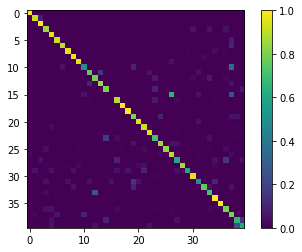

In [21]:
plt.imshow(matrix)
plt.colorbar()
plt.show()

## Here ends standard code

In [ ]:
#TEST to study knn function
x = tf.reshape(tf.range(60), (-1, 1, 1, 1))# shape = (60, 1, 1, 1)
x = tf.tile(x, (1, 20, 10, 1))# shape = (60, 20, 10, 1)
x = tf.concat([x, x], axis=3)# shape = (60, 20, 10, 2)

fts = tf.reshape(tf.range(60), (-1, 1, 1))# shape = (60, 1, 1)
fts = tf.tile(fts, (1, 20, 20))# shape = (60, 20, 20)

fts = tf.gather_nd(fts, x)# shape = (60, 20, 10, 20)
print( fts )

In the algorithm in reality doesn't happen the conctenate step... the edge conv layers just follow each others, so we should change the 'for' of edge conv to allow to save output on each step and the concatenate all them togheter

In [ ]:
setting_conv_params = [
    (20, (64, 64, 64)),  
    (20, (64, 64, 64)),
    (20, (128, 128, 128)),
    (20, (256, 256, 256)),
    ]

fts_dict = {}
for layer_idx, layer_param in enumerate(setting_conv_params):
    fts += fts
    #things that output our fps
    string = 'fts_%d' % (layer_idx)
    fts_dict[string]=fts
print(fts_dict)

fts =tf.concat([fts_dict['fts_0'], fts_dict['fts_1'], fts_dict['fts_2'], fts_dict['fts_3']], axis=-1)
print(fts.shape)
fts = keras.layers.Conv2D(60, kernel_size=(1, 1), strides=1)(fts)#60 will be 1024 in the algorithm... and so N
print(fts.shape)

In [17]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))